Epoch 1: Train Accuracy: 59.84%, Test Accuracy: 84.13%
Epoch 2: Train Accuracy: 87.39%, Test Accuracy: 87.87%
Epoch 3: Train Accuracy: 89.19%, Test Accuracy: 89.60%
Epoch 4: Train Accuracy: 90.22%, Test Accuracy: 88.72%
Epoch 5: Train Accuracy: 90.62%, Test Accuracy: 89.70%
Epoch 6: Train Accuracy: 91.00%, Test Accuracy: 90.68%
Epoch 7: Train Accuracy: 91.26%, Test Accuracy: 90.03%
Epoch 8: Train Accuracy: 91.59%, Test Accuracy: 91.31%
Epoch 9: Train Accuracy: 91.83%, Test Accuracy: 91.21%
Epoch 10: Train Accuracy: 91.78%, Test Accuracy: 92.00%
Epoch 11: Train Accuracy: 92.10%, Test Accuracy: 91.86%
Epoch 12: Train Accuracy: 92.06%, Test Accuracy: 92.49%
Epoch 13: Train Accuracy: 92.21%, Test Accuracy: 92.07%
Epoch 14: Train Accuracy: 92.20%, Test Accuracy: 92.22%
Epoch 15: Train Accuracy: 92.34%, Test Accuracy: 92.29%
Epoch 16: Train Accuracy: 92.44%, Test Accuracy: 92.29%
Epoch 17: Train Accuracy: 92.64%, Test Accuracy: 91.91%
Epoch 18: Train Accuracy: 92.41%, Test Accuracy: 92.06%
E

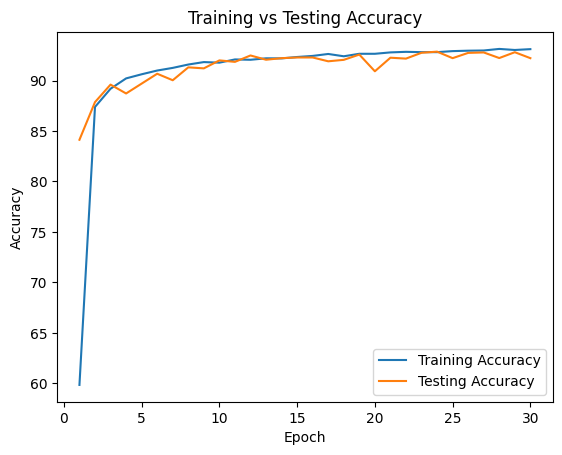

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd

# Provided parameter values
a = np.array([1.44459561, 1.4909716, 1.29900401, 1.59823275, 1.95377401,
              1.29692538, 1.3884494, 1.41366705, 1.4720679, 1.94549286,
              1.42256119, 1.35419586, 1.0655931, 1.4807465, 3.57915218,
              1.28707514, 1.29840168, 1.42614346, 2.301248, 1.82484445,
              1.37406175, 1.32049406, 1.48991211, 2.36839102, 2.57548982])
OD = np.array([10.62209668, 5.29927502, 5.24461367, 3.95714724, 3.53289089,
               4.90284341, 4.77882344, 4.21487304, 2.88143791, 3.68379522,
               7.11055405, 6.37264251, 5.52053175, 4.6822641, 3.91513311,
               3.79516812, 16.75179172, 4.82518489, 3.90599822, 4.43170833,
               4.68538009, 5.17359904, 5.77046094, 4.69307385, 4.32273257])
g = np.array([1018.98154797, 2459.73045748, 1571.1443399, 4717.39214842,
              7757.19215507, 1678.80384039, 2371.79623817, 2763.04246768,
              5398.06831678, 6639.08957198, 1498.46771748, 1437.98348092,
              896.57655106, 2596.58011685, 15084.55697028, 2336.91028423,
              456.33896778, 2464.47850684, 8199.06494407, 4530.89552788,
              2122.01729478, 1659.39463412, 2229.42490177, 6774.64313489,
              8393.47117689])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Parameter(torch.rand(25, 144) / 40000)
        self.fc2 = nn.Parameter(torch.rand(10, 25) / 200)
        #self.dropout = nn.Dropout(0.5)
        self.a_ = torch.tensor(a, dtype=torch.float32)
        self.OD = torch.tensor(OD, dtype=torch.float32)
        self.g = torch.tensor(g, dtype=torch.float32)

    def forward(self, x):
        x = x.view(-1, 144)
        x = F.linear(x, abs(self.fc1))
        #x = self.dropout(x)
        x = self.a_ * torch.exp(-self.OD * self.g / (x * 12800 + self.g))
        #x = self.dropout(x)
        out = F.linear(x, abs(self.fc2))
        return out

def train(model, device, train_loader, optimizer):
    model.train()
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, val_accuracy

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                       ]))
    train_size = int(0.75 * len(dataset1))
    val_size = int(0.10 * len(dataset1))
    test_size = len(dataset1) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset1, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    epochs = 30
    train_accuracies = []
    test_accuracies = []
    for epoch in range(1, epochs + 1):
        train_accuracy = train(model, device, train_loader, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plotting the training and testing accuracies
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()